In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_CATEGORIZADOS
from src.graficos import plot_coeficientes, plot_residuos

sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [3]:
df = pd.read_parquet(DADOS_CATEGORIZADOS)

df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   idade               442 non-null    int8    
 1   sexo                442 non-null    int8    
 2   imc                 442 non-null    float32 
 3   pressao_media       442 non-null    float32 
 4   colesterol_total    442 non-null    int16   
 5   ldl                 442 non-null    float32 
 6   hdl                 442 non-null    float32 
 7   triglicerides       442 non-null    float32 
 8   glicose             442 non-null    int8    
 9   target              442 non-null    int16   
 10  colesterol_hdl_cat  442 non-null    category
dtypes: category(1), float32(5), int16(2), int8(3)
memory usage: 12.3 KB


In [5]:
colunas_power_transform = ["imc", "ldl", "hdl", "colesterol_total"]

coluna_target = ["target"]

coluna_ordinal_encoder = ["colesterol_hdl_cat"]

coluna_one_hot_encoder = ["sexo"]

colunas_standard_scaler = [
    coluna
    for coluna in df.columns
    if coluna not in colunas_power_transform + coluna_target + coluna_ordinal_encoder + coluna_one_hot_encoder
]

colunas_standard_scaler

['idade', 'pressao_media', 'triglicerides', 'glicose']

In [6]:
categorias_ordinal_encoder = [
    ["2-3", "4-5", "6+"],
]

In [7]:
X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [8]:
preprocessamento = ColumnTransformer(
    [
        ("power_transform", PowerTransformer(method="box-cox"), colunas_power_transform),
        ("standard_scaler", StandardScaler(), colunas_standard_scaler),
        ("ordinal_encoder", OrdinalEncoder(categories=categorias_ordinal_encoder), coluna_ordinal_encoder),
        ("one_hot_encoder", OneHotEncoder(drop="if_binary"), coluna_one_hot_encoder),
    ]
)

In [9]:
pipeline = Pipeline([
    ("preprocessor", preprocessamento),
    ("reg", LinearRegression())
])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

In [10]:
regressor = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=QuantileTransformer(n_quantiles=20, output_distribution="normal"),
)

regressor

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

In [11]:
regressor.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('power_transform',
                                                                                       PowerTransformer(method='box-cox'),
                                                                                       ['imc',
                                                                                        'ldl',
                                                                                        'hdl',
                                                                                        'colesterol_total']),
                                                                                      ('standard_scaler',
                                                                                       StandardScaler(),
                                                                                       ['idade',
                                                                                        'pressao_media',
                                                                                        'triglicerides',
                                                                                        'glicose']),
                                                                                      ('ordinal_encoder',
                                                                                       OrdinalEncoder(categories=[['2-3',
                                                                                                                   '4-5',
                                                                                                                   '6+']]),
                                                                                       ['colesterol_hdl_cat']),
                                                                                      ('one_hot_encoder',
                                                                                       OneHotEncoder(drop='if_binary'),
                                                                                       ['sexo'])])),
                                                     ('reg',
                                                      LinearRegression())]),
                           transformer=QuantileTransformer(n_quantiles=20,
                                                           output_distribution='normal'))

In [12]:
regressor.regressor_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('power_transform',
                                                  PowerTransformer(method='box-cox'),
                                                  ['imc', 'ldl', 'hdl',
                                                   'colesterol_total']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['idade', 'pressao_media',
                                                   'triglicerides',
                                                   'glicose']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['2-3',
                                                                              '4-5',
                                                                              '6+']]),
                                                  ['colesterol_hdl_cat']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['sexo'])])),
                ('reg', LinearRegression())])

In [13]:
regressor.transformer_

QuantileTransformer(n_quantiles=20, output_distribution='normal')

In [14]:
regressor.regressor_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('power_transform',
                                  PowerTransformer(method='box-cox'),
                                  ['imc', 'ldl', 'hdl', 'colesterol_total']),
                                 ('standard_scaler', StandardScaler(),
                                  ['idade', 'pressao_media', 'triglicerides',
                                   'glicose']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['2-3', '4-5',
                                                              '6+']]),
                                  ['colesterol_hdl_cat']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'), ['sexo'])]),
 'reg': LinearRegression()}

In [15]:
regressor.regressor_["reg"].coef_

array([ 0.31482693,  0.31866869,  0.04081163, -0.54393916,  0.02066515,
        0.16633017,  0.45013303,  0.0332632 ,  0.18527508, -0.3168929 ])

In [16]:
regressor.regressor_["reg"].intercept_

np.float64(0.016796168975689862)

In [17]:
regressor.regressor_.named_steps

{'preprocessor': ColumnTransformer(transformers=[('power_transform',
                                  PowerTransformer(method='box-cox'),
                                  ['imc', 'ldl', 'hdl', 'colesterol_total']),
                                 ('standard_scaler', StandardScaler(),
                                  ['idade', 'pressao_media', 'triglicerides',
                                   'glicose']),
                                 ('ordinal_encoder',
                                  OrdinalEncoder(categories=[['2-3', '4-5',
                                                              '6+']]),
                                  ['colesterol_hdl_cat']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(drop='if_binary'), ['sexo'])]),
 'reg': LinearRegression()}

In [18]:
regressor.regressor_["preprocessor"].feature_names_in_

array(['idade', 'sexo', 'imc', 'pressao_media', 'colesterol_total', 'ldl',
       'hdl', 'triglicerides', 'glicose', 'colesterol_hdl_cat'],
      dtype=object)

In [19]:
regressor.regressor_["preprocessor"].get_feature_names_out()

array(['power_transform__imc', 'power_transform__ldl',
       'power_transform__hdl', 'power_transform__colesterol_total',
       'standard_scaler__idade', 'standard_scaler__pressao_media',
       'standard_scaler__triglicerides', 'standard_scaler__glicose',
       'ordinal_encoder__colesterol_hdl_cat', 'one_hot_encoder__sexo_2'],
      dtype=object)

In [20]:
coefs = dataframe_coeficientes(
    regressor.regressor_["reg"].coef_,
    regressor.regressor_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
power_transform__colesterol_total,-0.543939
one_hot_encoder__sexo_2,-0.316893
standard_scaler__idade,0.020665
standard_scaler__glicose,0.033263
power_transform__hdl,0.040812
standard_scaler__pressao_media,0.166330
ordinal_encoder__colesterol_hdl_cat,0.185275
power_transform__imc,0.314827
power_transform__ldl,0.318669
standard_scaler__triglicerides,0.450133


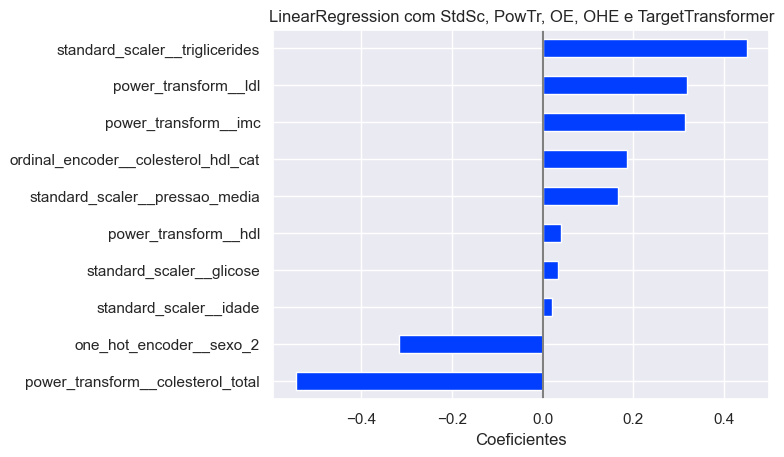

In [21]:
plot_coeficientes(coefs, titulo="LinearRegression com StdSc, PowTr, OE, OHE e TargetTransformer")

In [22]:
df.head()

,idade,sexo,imc,pressao_media,colesterol_total,ldl,hdl,triglicerides,glicose,target,colesterol_hdl_cat
0,59,2,32.099998,101.0,157,93.199997,38.0,4.8598,87,151,4-5
1,48,1,21.600000,87.0,183,103.199997,70.0,3.8918,69,75,2-3
2,72,2,30.500000,93.0,156,93.599998,41.0,4.6728,85,141,4-5
3,24,1,25.299999,84.0,198,131.399994,40.0,4.8903,89,206,4-5
4,50,1,23.000000,101.0,192,125.400002,52.0,4.2905,80,135,4-5


In [23]:
y.values.reshape(-1, 1)[:5]

array([[151],
       [ 75],
       [141],
       [206],
       [135]], dtype=int16)

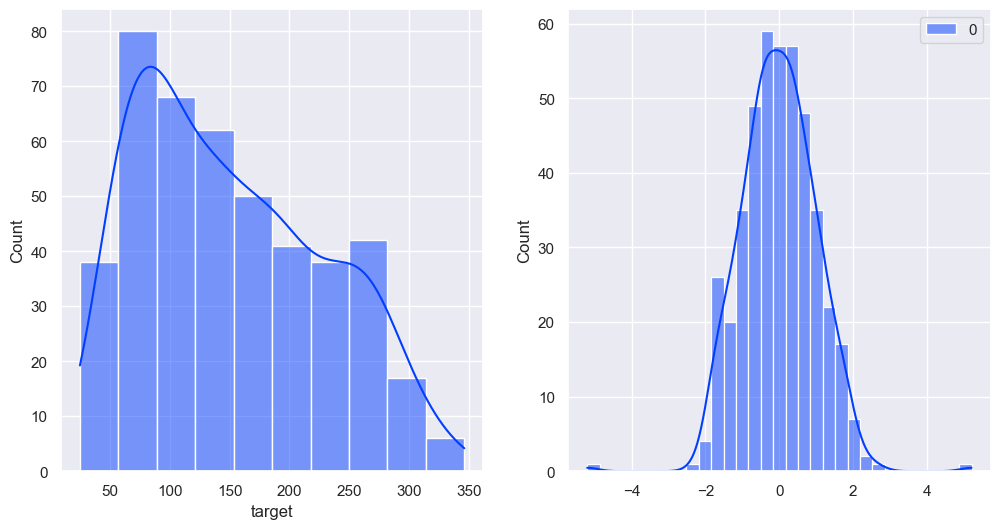

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(y, ax=axs[0], kde=True)

y_transformado = regressor.transformer_.transform(y.values.reshape(-1, 1))

sns.histplot(y_transformado, ax=axs[1], kde=True)

plt.show()

In [25]:
y.describe()

count    442.000000
mean     152.133484
std       77.093005
min       25.000000
25%       87.000000
50%      140.500000
75%      211.500000
max      346.000000
Name: target, dtype: float64

In [26]:
regressor.transformer_.inverse_transform([[-5]])

array([[25.00014161]])

In [27]:
regressor.transformer_.inverse_transform([[0]])

array([[141.13157895]])

In [28]:
regressor.transformer_.inverse_transform([[5]])

array([[345.99965688]])

In [29]:
y_pred = regressor.predict(X_test)

y_pred

array([137.13804809, 175.9280104 , 137.50126103, 280.6940192 ,
       103.8351916 ,  87.25667872, 244.35075473, 186.27543078,
        75.78253399,  97.1624667 ,  78.68654154, 172.69909766,
        61.3465752 , 205.92584434,  81.14755917, 121.09626707,
       225.20235493, 258.1260605 , 216.9489139 , 213.81273403,
       230.07121382,  82.54303262,  63.93992937, 196.08871897,
       142.07628299, 155.93475813, 189.80473365, 174.66389649,
        55.79468702,  98.09450419, 166.33769594,  80.00170896,
       134.34988279, 182.29728484, 173.73186032, 192.72568875,
       118.7494195 , 104.80070235, 134.39190613,  59.11789906,
        62.53914681,  83.83396963, 170.99766818, 147.46429373,
       173.09133644,  60.43741842,  71.81993241,  87.75908942,
        55.37311604, 172.11635978, 151.85110262,  63.06290598,
        91.72526199,  89.28529476, 159.92494006, 138.20869359,
        84.92843236, 224.98998885, 104.78619938,  66.91374346,
       200.10504355, 227.28826976, 124.0441139 ,  80.23

In [30]:
mean_absolute_error(y_test, y_pred)

np.float64(42.03921055830703)

In [31]:
mean_squared_error(y_test, y_pred)

np.float64(2908.2520511094203)

In [32]:
root_mean_squared_error(y_test, y_pred)

np.float64(53.92821201476478)

In [41]:
r2_score(y_test, y_pred)

0.45108177546562633

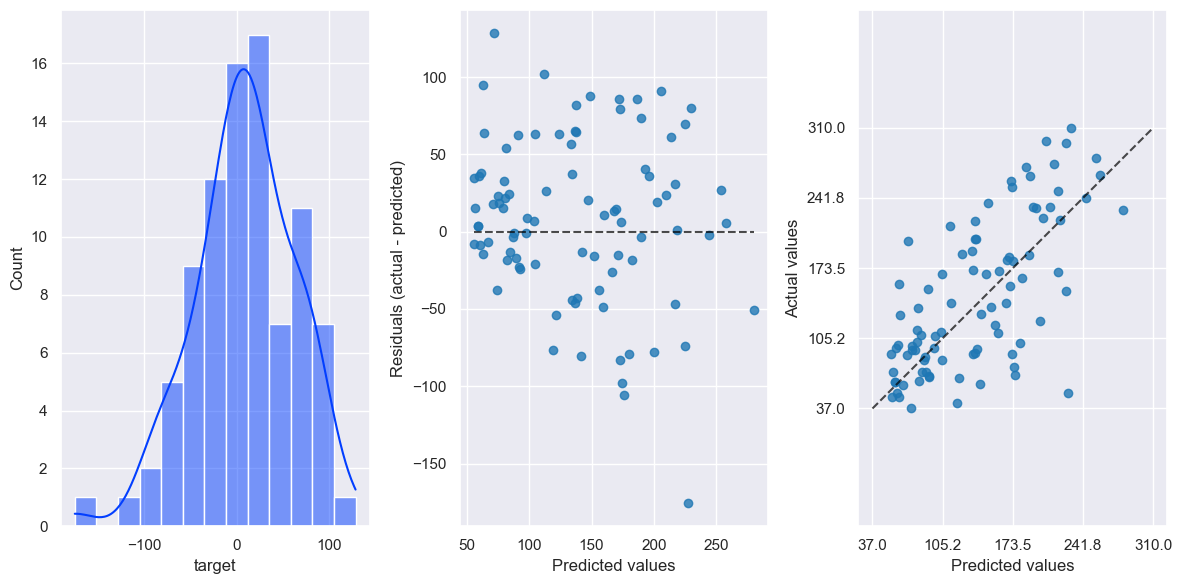

In [34]:
plot_residuos(y_test, y_pred)